# Introduction

This report presents an analysis of Airbnb reviews for properties in Barossa Valley, Australia. The goal is to understand the sentiment and key aspects of guest experiences.

# Data Introduction

let's take a look at our data

importing required libraries

In [ ]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize, wordpunct_tokenize, blankline_tokenize
from wordcloud import WordCloud
import warnings
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
import re
import matplotlib.dates as mdates
from collections import Counter
from nltk import bigrams, trigrams
from nltk.sentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex

# Suppress specific warning
warnings.filterwarnings("ignore")


In [ ]:
# Reading data
df = pd.read_csv("reviews.csv")
df.head(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1125097,7269778,2013-09-13,3053083,Stephen,While I didnt have the pleasure of meeting Hea...
1,1125097,10081118,2014-01-29,1898281,Rus,Great host and amazing accommodation! \r<br/>...
2,1125097,10335170,2014-02-14,2725224,Teresa,"A lovely and convenient location, surrounded b..."
3,1125097,10881952,2014-03-11,8982612,Kathy,A wonderful experience from start to finish . ...
4,1125097,11872081,2014-04-17,10977428,Phillip,The coach house is in a lovely location. We we...


We have listing_id, id, date of the review, reviewer_id, reviewer_name and the comments or you can say the content of the review

In [ ]:
df.info()

In [ ]:

# Function to detect language
def is_english(text):
    try:
        if isinstance(text, str):
            return detect(text) == 'en'
        return False
    except LangDetectException:
        return False

# Apply the function to the 'text' column and filter out non-English reviews
df['is_english'] = df['comments'].apply(is_english)
english_reviews_df = df[df['is_english']]

# Display the filtered DataFrame
print(english_reviews_df[['comments']])


so we have 18867 observations or reviews you can say. before working with the data let's pre-process the reviews as it is the text data

In [ ]:


# Function to preprocess text
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back to string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

# Apply the preprocessing function to the 'text' column
english_reviews_df['cleaned_text'] = english_reviews_df['comments'].apply(preprocess_text)

# Display the cleaned DataFrame
print(english_reviews_df[['comments', 'cleaned_text']])


                                                comments  \
0      While I didnt have the pleasure of meeting Hea...   
1      Great host and amazing accommodation!  \r<br/>...   
2      A lovely and convenient location, surrounded b...   
3      A wonderful experience from start to finish . ...   
4      The coach house is in a lovely location. We we...   
...                                                  ...   
19142  Highly recommend Rebecca's place.<br/>Renovate...   
19143  Nice spot close to main street very comfortabl...   
19144  Good location, easy to find and they answered ...   
19145  Great location, close to the town centre. <br/...   
19146  We LOVED our stay, the property is so calm and...   

                                            cleaned_text  
0      didnt pleasure meeting heather person anything...  
1      great host amazing accommodation went celebrat...  
2      lovely convenient location surrounded grape fa...  
3      wonderful experience start finish ba

C:\Users\Haier\AppData\Local\Temp\ipykernel_20056\4064625842.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews_df['cleaned_text'] = english_reviews_df['comments'].apply(preprocess_text)


# Monthly Review Counts of Barossa Valley Australia Airbnb

C:\Users\Haier\AppData\Local\Temp\ipykernel_20056\3095751035.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews_df['date'] = pd.to_datetime(english_reviews_df['date'])
C:\Users\Haier\AppData\Local\Temp\ipykernel_20056\3095751035.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews_df['month'] = english_reviews_df['date'].dt.to_period('M')


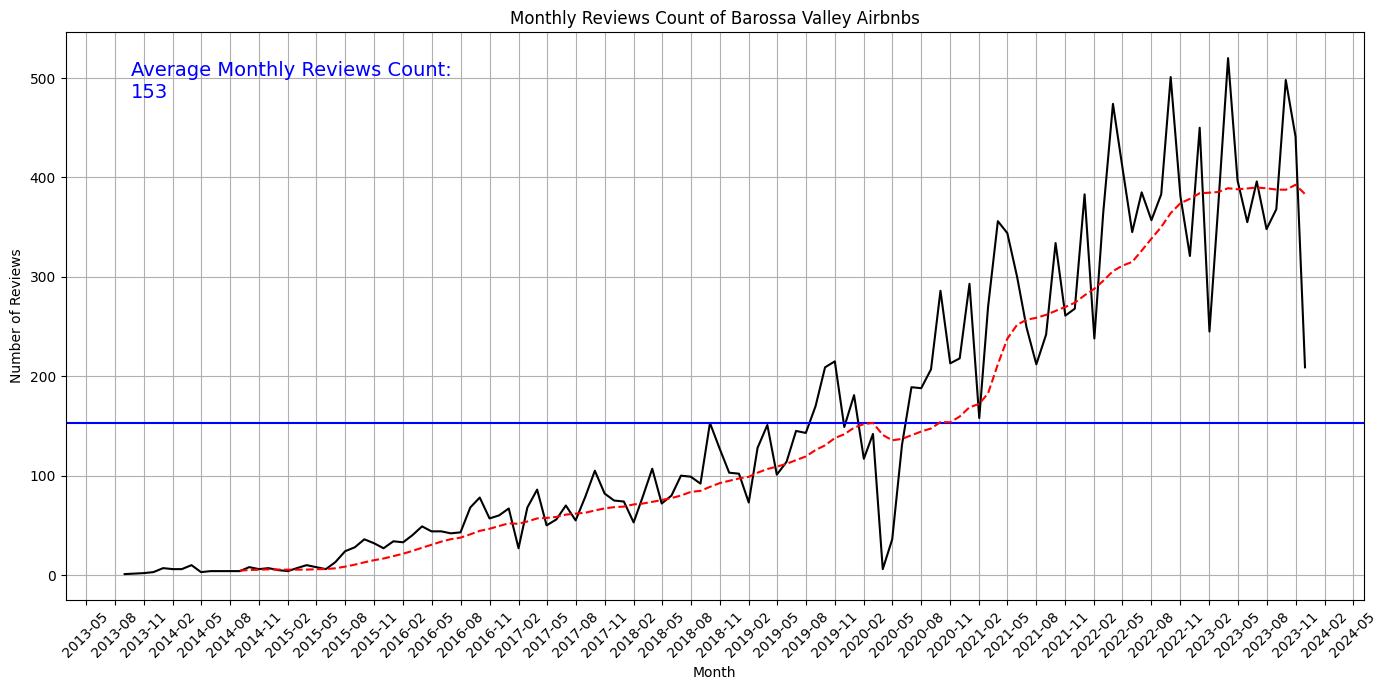

In [ ]:
def plot_monthly_review_counts(reviews_df, date_column, title='Monthly Reviews Count'):
    """
    Plots the monthly review counts, average review line, and a trendline.

    Parameters:
    reviews_df (pd.DataFrame): DataFrame containing the review data.
    date_column (str): Name of the column containing the date of the reviews.
    title (str): Title of the plot.

    Returns:
    None: Displays the plot.
    """
    # Convert the date column to datetime
    reviews_df[date_column] = pd.to_datetime(reviews_df[date_column])

    # Group by month and count reviews
    reviews_df['month'] = reviews_df[date_column].dt.to_period('M')
    monthly_reviews = reviews_df.groupby('month').size().reset_index(name='count')
    monthly_reviews['month'] = monthly_reviews['month'].dt.to_timestamp()

    # Calculate the average monthly reviews count
    average_reviews = monthly_reviews['count'].mean()

    # Plot the data
    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot the review trend
    ax.plot(monthly_reviews['month'], monthly_reviews['count'], color='black')

    # Plot the average line
    ax.axhline(y=average_reviews, color='blue', linestyle='-')
    ax.text(0.05, 0.95, f'Average Monthly Reviews Count:\n{int(average_reviews)}', transform=ax.transAxes,
            fontsize=14, verticalalignment='top', color='blue')

    # Add a trendline (moving average)
    monthly_reviews['trend'] = monthly_reviews['count'].rolling(window=12).mean()
    ax.plot(monthly_reviews['month'], monthly_reviews['trend'], color='red', linestyle='--')

    # Format the plot
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel('Number of Reviews')
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
plot_monthly_review_counts(english_reviews_df, 'date', 'Monthly Reviews Count of Barossa Valley Australia Airbnb')


## Insights
The plot illustrates the monthly review count for Airbnbs in the Barossa Valley, Australia, over the period from 2013 to 2024.

1. **Monthly Reviews Count (Black Line)**:
   - The black line represents the number of reviews each month.
   - From 2013 to around 2018, the number of monthly reviews was relatively low and stable.
   - Starting from 2018, there is a noticeable upward trend in the number of reviews, indicating an increase in the popularity of Airbnbs in the Barossa Valley.

2. **Trend Line (Red Dashed Line)**:
   - The red dashed line represents the moving average trend line (using a 12-month window), which smooths out short-term fluctuations and highlights longer-term trends.
   - This line clearly shows a consistent upward trend from 2015 onwards, with some fluctuations around the general upward trajectory.
   - There are noticeable peaks and troughs, particularly around the years 2020 to 2022, which could be associated with external factors such as travel restrictions or seasonal variations.

3. **Average Monthly Reviews Count (Blue Line)**:
   - The blue horizontal line represents the average monthly review count, which is approximately 153.
   - The text "Average Monthly Reviews Count: 153" is annotated on the plot to highlight this value.
   - For much of the period before 2018, the monthly review counts are below this average. From 2018 onwards, the counts frequently exceed the average, particularly in the latter part of the plot.

4. **Key Observations**:
   - **Initial Stability**: The number of reviews remained quite stable and low until around 2015, with slight variations but no significant growth.
   - **Growth Period**: Starting from 2015, there is a noticeable growth in the number of reviews, which becomes more pronounced from 2018 onwards. This growth trend continues until the end of the observed period.
   - **Impact of External Factors**: There are some significant dips and peaks in the review counts, especially around early 2020 and late 2021. These could be due to various factors such as the COVID-19 pandemic affecting travel patterns.

Overall, the plot effectively visualizes the growing popularity of Airbnbs in the Barossa Valley, highlighting both short-term fluctuations and the longer-term trend. The annotations and trend lines help to contextualize the data, making it easier to understand the underlying patterns and average values.

# Top 20 most Frequent Words in Reviews

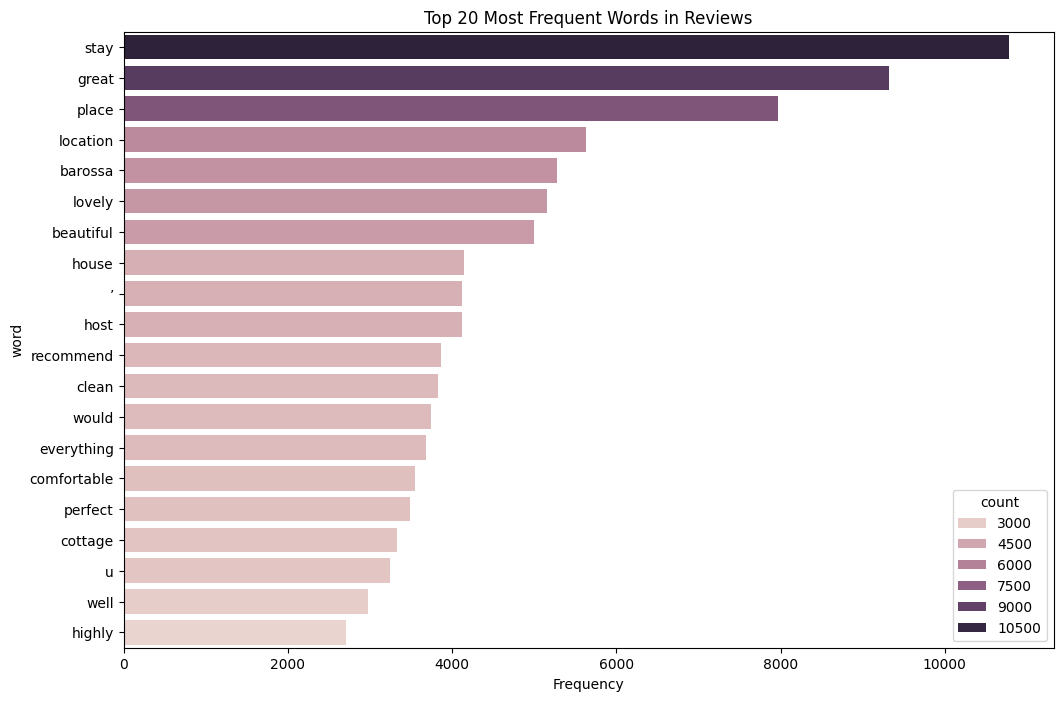

In [ ]:
def plot_top_words(reviews_df, text_column, num_words=20):
    """
    Plots the top N most frequent words from cleaned review text.

    Parameters:
    reviews_df (pd.DataFrame): DataFrame containing the cleaned review text data.
    text_column (str): Name of the column containing the cleaned review text.
    num_words (int): Number of top frequent words to display (default is 20).

    Returns:
    None: Displays the plot.
    """
    # Tokenize the text into words
    all_words = []
    for review in reviews_df[text_column]:
        tokens = word_tokenize(review.lower())
        all_words.extend(tokens)

    # Count the frequency of each word
    word_freq = Counter(all_words)

    # Get the top N most frequent words
    top_words = word_freq.most_common(num_words)

    # Prepare data for plotting
    words, counts = zip(*top_words)
    top_words_df = pd.DataFrame({'word': words, 'count': counts})

    # Plot the top N most frequent words using Seaborn
    plt.figure(figsize=(12, 8))
    sns.barplot(x='count', y='word', data=top_words_df, hue='count', dodge=False)
    plt.xlabel('Frequency')
    plt.title(f'Top {num_words} Most Frequent Words in Reviews')
    plt.show()

# Example usage:
plot_top_words(english_reviews_df, 'cleaned_text', 20)

## Insights



* In the reviews for Barossa Valley, Australia, the most frequently mentioned word is "stay," followed closely by "great," "place," and "location." These terms suggest that reviewers frequently discuss their overall experience and the qualities of their accommodations.

* The prominence of the word "stay" indicates that visitors often comment on the duration and quality of their visit. The word "great" suggests a generally positive sentiment towards the experience in Barossa Valley. The mention of "place" and "location" highlights the importance of the geographical and environmental aspects of the region to the visitors.



* The word "house" suggests that many reviews may be related to staying in vacation homes or cottages, which are popular accommodation types in the region. The presence of words like "host" and "recommend" indicates that the hospitality and recommendations from locals or hosts play a crucial role in enhancing the visitor experience.

* Words like "clean," "comfortable," and "perfect" suggest that cleanliness, comfort, and overall perfection of the accommodations are highly appreciated by the reviewers. The frequent use of "cottage" indicates that cottages are a common and preferred type of lodging in Barossa Valley.

* Lastly, words such as "highly," "everything," and "well" point towards positive reviews where guests express their satisfaction with various aspects of their stay.

* Overall, this analysis shows that tourists in Barossa Valley highly value the natural beauty, hospitality, and quality of accommodations, making it a desirable destination.



# Trends of most common words over the time

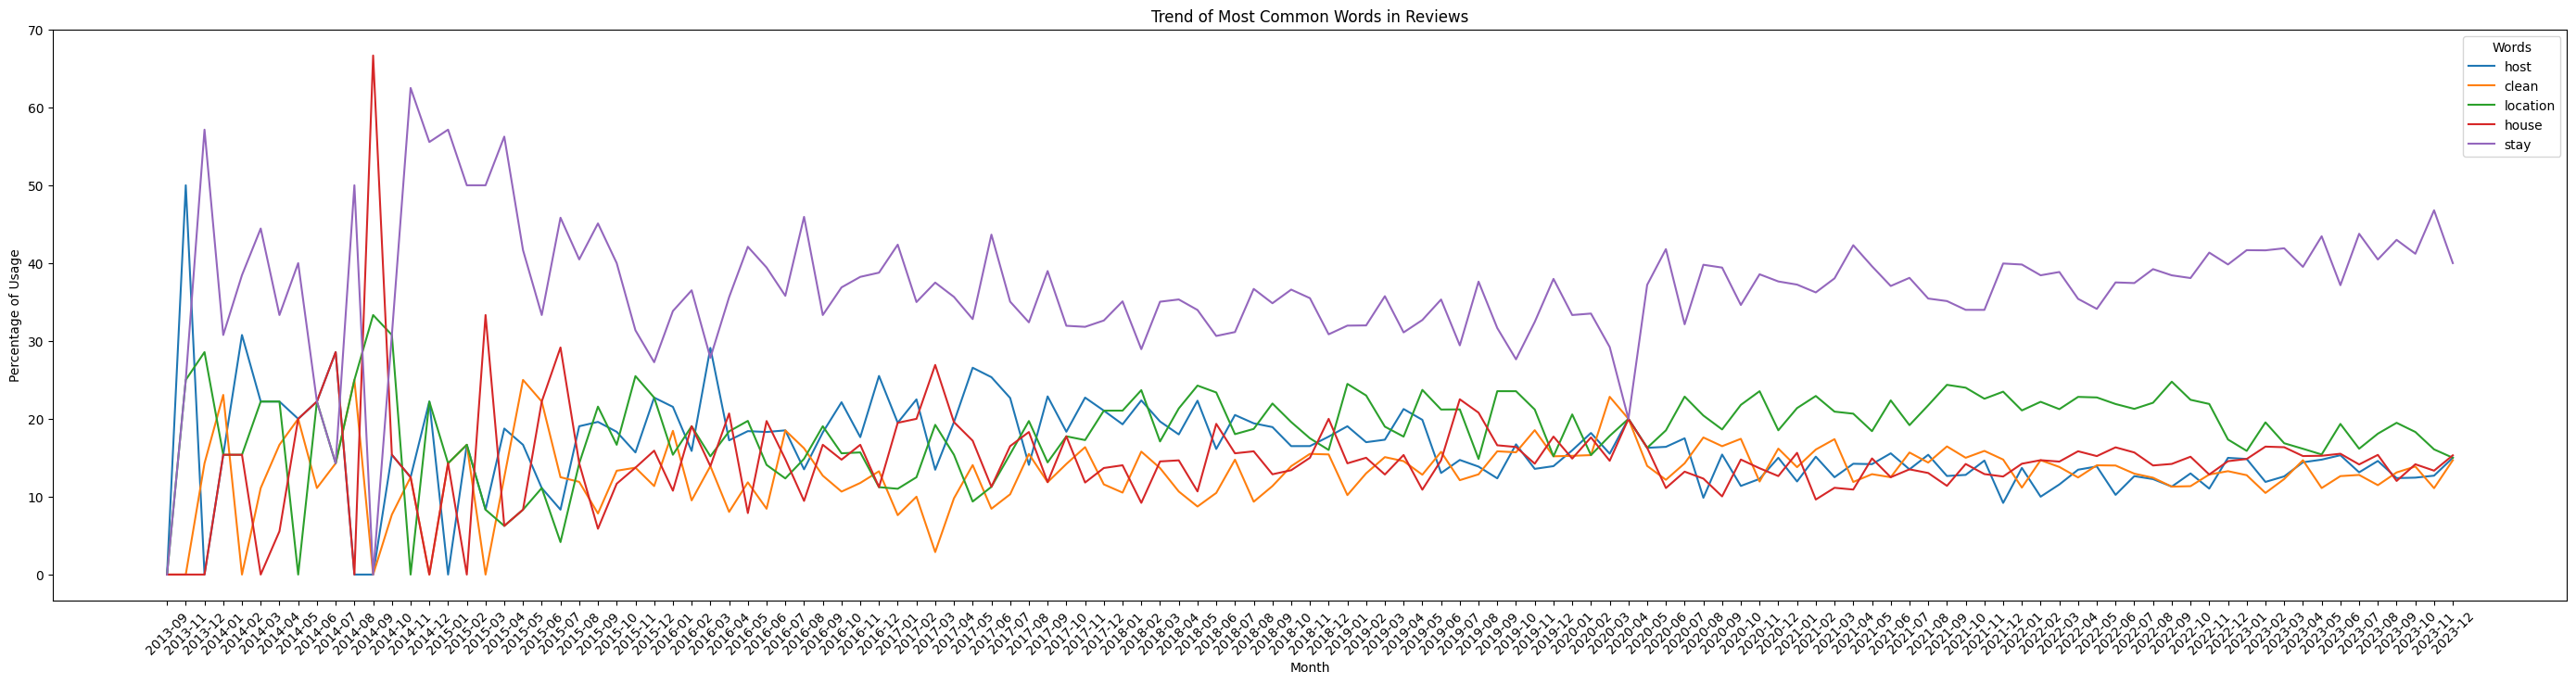

In [ ]:
def plot_word_trends_over_time(reviews_df, date_column, text_column, words_of_interest, title='Trend of Most Common Words in Reviews'):
    """
    Plots the trend of the most common words over time.

    Parameters:
    reviews_df (pd.DataFrame): DataFrame containing the review data.
    date_column (str): Name of the column containing the date of the reviews.
    text_column (str): Name of the column containing the cleaned review text.
    words_of_interest (list): List of words to track.
    title (str): Title of the plot (default is 'Trend of Most Common Words in Reviews').

    Returns:
    None: Displays the plot.
    """
    # Ensure the date column is in datetime format
    reviews_df[date_column] = pd.to_datetime(reviews_df[date_column])

    # Create a 'month' column
    reviews_df['month'] = reviews_df[date_column].dt.to_period('M')

    # Initialize a DataFrame to store the counts
    months_sorted = sorted(reviews_df['month'].unique())
    monthly_counts = pd.DataFrame(columns=words_of_interest, index=months_sorted)

    # Tokenize the cleaned text and calculate word frequencies
    for month in monthly_counts.index:
        monthly_reviews = reviews_df[reviews_df['month'] == month][text_column].dropna()
        all_words = [word for review in monthly_reviews for word in review.split()]
        word_freq = Counter(all_words)
        for word in words_of_interest:
            monthly_counts.loc[month, word] = word_freq[word]

    # Fill NaN values with 0 to handle months with no reviews
    monthly_counts.fillna(0, inplace=True)

    # Calculate the percentage of usage for each word, avoid division by zero
    total_counts = monthly_counts.sum(axis=1)
    total_counts[total_counts == 0] = 1  # Replace zero with one to avoid division by zero

    monthly_percentage = monthly_counts.div(total_counts, axis=0) * 100
    monthly_percentage = monthly_percentage.astype(float)

    # Plot the data
    plt.figure(figsize=(35, 8))

    # Convert index values to strings for plotting
    x_values = [str(month) for month in monthly_percentage.index]

    for word in words_of_interest:
        plt.plot(x_values, monthly_percentage[word], label=word)

    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel('Percentage of Usage')
    plt.legend(title='Words')
    plt.xticks(rotation=45)
    plt.show()

# Example usage:
plot_word_trends_over_time(english_reviews_df, 'date', 'cleaned_text', ['host', 'clean', 'location', 'house', 'stay'])


The provided plot shows the monthly percentage of usage for five common words ("host," "clean," "location," "house," and "stay") in reviews over time.

### Interpretation:

1. **Stay (Purple Line)**:
   - The word "stay" consistently has the highest percentage of usage across the time period. This indicates that guests frequently talk about their overall experience or the duration of their stay.
   - The percentage fluctuates but remains significantly higher than the other words, suggesting it's a primary topic in most reviews.

2. **Location (Green Line)**:
   - The word "location" shows a steady presence in the reviews, maintaining a relatively consistent percentage of usage.
   - This indicates that the location of the accommodations is an important factor for guests, and they often comment on it.

3. **House (Red Line)**:
   - The word "house" also maintains a consistent presence, similar to "location," but with more fluctuation.
   - This suggests that many reviews are about staying in houses, and guests frequently mention their accommodation type.

4. **Host (Blue Line)**:
   - The word "host" has a variable percentage of usage over time but remains a common topic.
   - This highlights the importance of the host's role in the guest experience, with guests often discussing the host's behavior and service.

5. **Clean (Orange Line)**:
   - The word "clean" shows a declining trend over time, with significant fluctuations.
   - Initially, cleanliness was a more frequently mentioned topic, but its mention has decreased, suggesting either an improvement in cleanliness (leading to fewer complaints) or a shift in guest focus to other aspects.

### Suggested Actions:

1. **Focus on Cleanliness**:
   - Despite the initial high frequency of "clean," its usage has decreased over time. This could mean that while cleanliness may have improved, it remains a critical factor for guest satisfaction.
   - Ensure regular and thorough cleaning protocols are maintained and possibly enhanced to exceed guest expectations.

2. **Enhance Location Information**:
   - Since "location" is consistently mentioned, providing detailed information about the local area, nearby attractions, and transportation options could enhance guest satisfaction.
   - Consider creating a guide or app that offers recommendations for things to do and places to visit in the vicinity.

3. **Improve Host Interaction**:
   - The variable but frequent mention of "host" highlights the importance of the host-guest interaction.
   - Provide hosts with training on hospitality and customer service to ensure guests have a positive and memorable experience.
   - Encourage hosts to be responsive and helpful, as this can significantly impact reviews.

4. **Highlight Accommodation Types**:
   - The frequent mention of "house" suggests that guests value knowing what type of accommodation they will be staying in.
   - Clearly describe the type of accommodation in listings, emphasizing unique features and benefits.

5. **Monitor Guest Feedback**:
   - Continuously monitor reviews to identify emerging trends and areas for improvement.
   - Implement a feedback system to address guest concerns promptly and adapt to changing preferences.

By focusing on these areas, you can enhance the overall guest experience, leading to more positive reviews and potentially higher occupancy rates.

# Top 20 bigrams and trigrams

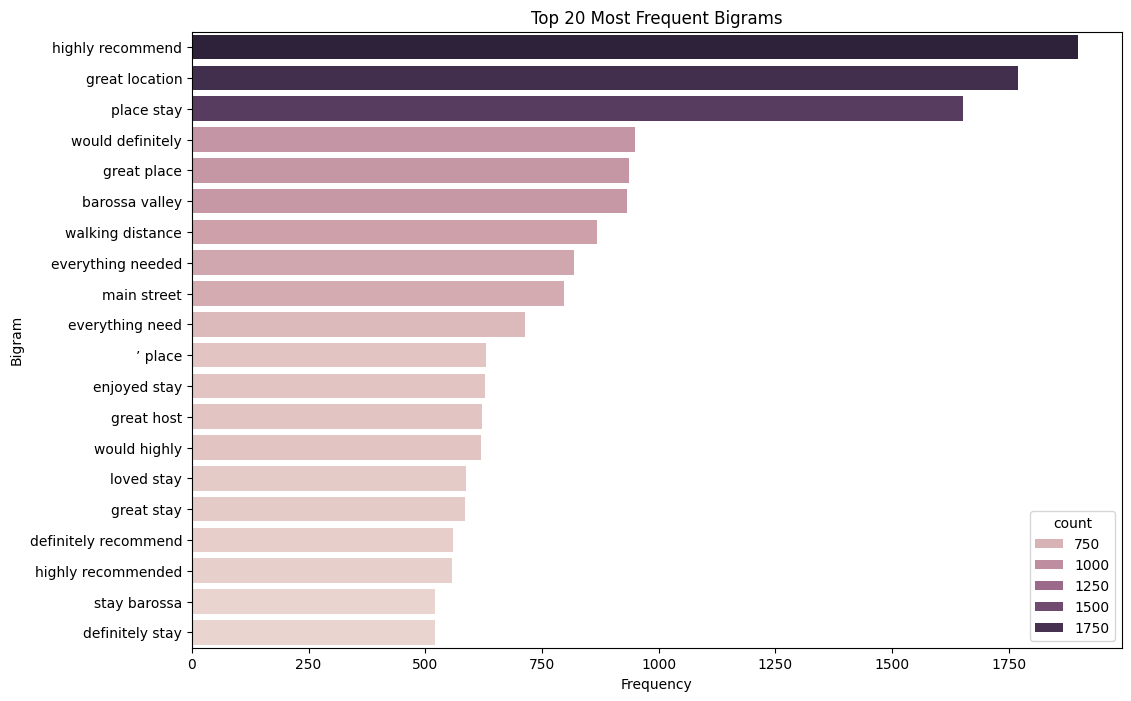

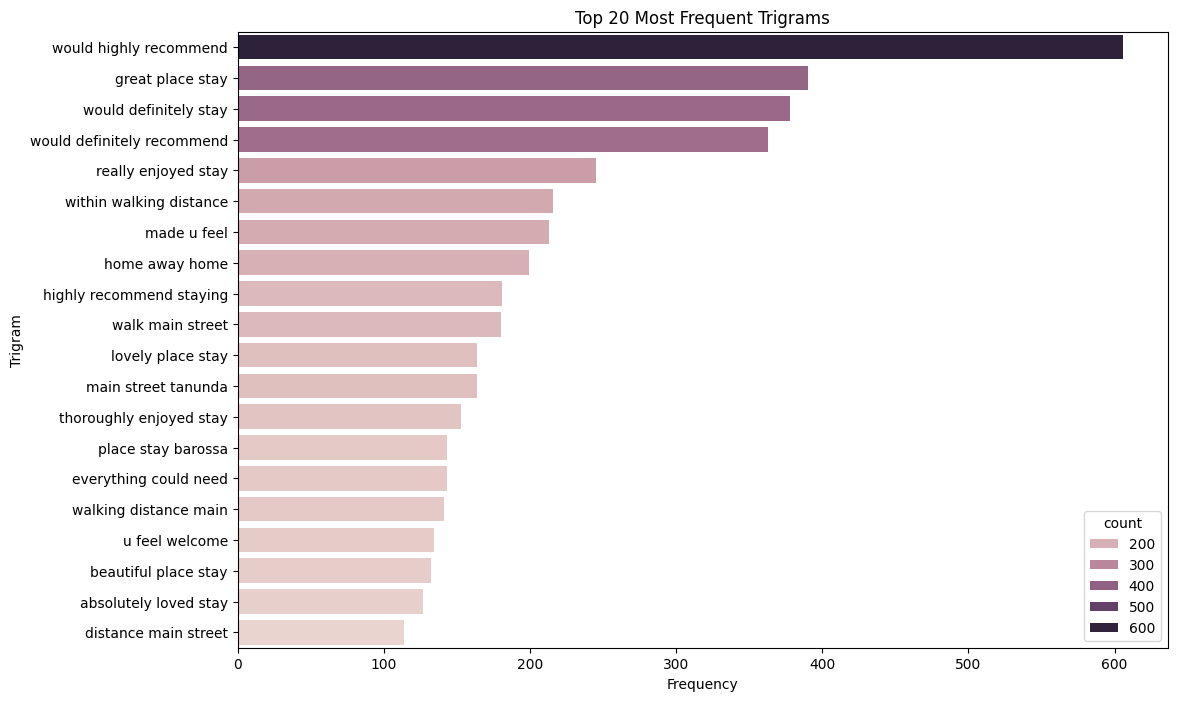

In [ ]:

def plot_top_ngrams(reviews_df, text_column, ngram_range=(2, 3), num_ngrams=20):
    """
    Plots the top N most common bigrams and trigrams from cleaned review text.

    Parameters:
    reviews_df (pd.DataFrame): DataFrame containing the cleaned review text data.
    text_column (str): Name of the column containing the cleaned review text.
    ngram_range (tuple): Range of n-grams to consider (default is (2, 3) for bigrams and trigrams).
    num_ngrams (int): Number of top n-grams to display (default is 20).

    Returns:
    None: Displays the plots.
    """
    text_data = reviews_df[text_column].values

    # Tokenize the text into words
    tokenized_text = [word_tokenize(sentence) for sentence in text_data]

    # Initialize lists to store n-grams
    ngrams_list = {n: [] for n in range(ngram_range[0], ngram_range[1] + 1)}

    # Generate n-grams
    for tokens in tokenized_text:
        for n in ngrams_list:
            ngrams_list[n].extend(list(nltk.ngrams(tokens, n)))

    # Flatten the lists and count the frequency of each n-gram
    ngram_freq = {n: Counter(ngrams_list[n]) for n in ngrams_list}

    # Get the top N most frequent n-grams
    top_ngrams = {n: ngram_freq[n].most_common(num_ngrams) for n in ngrams_list}

    # Plotting the n-grams
    for n in ngrams_list:
        ngrams_str = [' '.join(ngram) for ngram, count in top_ngrams[n]]
        counts = [count for ngram, count in top_ngrams[n]]
        top_ngrams_df = pd.DataFrame({'ngram': ngrams_str, 'count': counts})

        plt.figure(figsize=(12, 8))
        sns.barplot(x='count', y='ngram', data=top_ngrams_df, hue='count', dodge=False)
        plt.title(f'Top {num_ngrams} Most Frequent {n}-grams')
        plt.xlabel('Frequency')
        plt.ylabel(f'{n}-gram')
        plt.show()

# Example usage:
plot_top_ngrams(english_reviews_df, 'cleaned_text', (2, 3), 20)


### Interpretation of the Top 20 Trigrams Plot

The plot displays the top 20 most frequent trigrams (three-word combinations) in the reviews. Each bar represents the count of a specific trigram, indicating how often it appears in the reviews. Here are the key points and insights from the plot:

1. **Highly Positive Recommendations**:
   - The most frequent trigram is "would highly recommend," followed by similar phrases like "great place stay," "would definitely stay," and "would definitely recommend."
   - These trigrams suggest that guests are highly satisfied with their experience and are likely to recommend the place to others.

2. **Enjoyable Stays**:
   - Phrases like "really enjoyed stay" and "thoroughly enjoyed stay" indicate that guests find their stays enjoyable and pleasant.
   - Highlighting these experiences can attract potential guests looking for a positive and enjoyable stay.

3. **Walking Distance Convenience**:
   - Several trigrams such as "within walking distance," "walk main street," "main street tanunda," "walking distance main," and "distance main street" emphasize the convenience of being within walking distance to important locations.
   - This is a significant selling point and can be emphasized in marketing materials to attract guests who value convenience and accessibility.

4. **Comfort and Home-Like Feel**:
   - Trigrams like "home away home" and "made u feel" suggest that guests feel comfortable and at home during their stay.
   - Promoting the accommodation as a "home away from home" can appeal to guests seeking comfort and a welcoming atmosphere.

5. **Lovely and Beautiful Descriptions**:
   - Phrases like "lovely place stay" and "beautiful place stay" highlight the aesthetic appeal and pleasant environment of the accommodation.
   - Visual marketing materials can focus on showcasing the beauty and charm of the place.

6. **Barossa-Specific Mentions**:
   - The trigram "place stay barossa" indicates that guests frequently mention the location, Barossa Valley, which is a popular wine region in Australia.
   - Emphasizing the unique attributes and attractions of Barossa Valley can attract guests interested in wine tourism and the region's offerings.

### Suggested Actions Based on the Plot

1. **Leverage Positive Reviews**:
   - Use guest testimonials and reviews that include phrases like "would highly recommend" and "would definitely stay" in marketing campaigns to build trust and attract new guests.

2. **Highlight Walking Distance Convenience**:
   - Emphasize the convenience of being within walking distance to key attractions, restaurants, and amenities in your digital marketing efforts.
   - Create maps or guides that show what guests can access within walking distance from the accommodation.

3. **Promote Comfort and Home-Like Experience**:
   - Highlight the comfort and homely atmosphere in your listings and marketing materials. Use phrases like "home away from home" to appeal to guests seeking a cozy and welcoming environment.

4. **Showcase Aesthetic Appeal**:
   - Use high-quality images and videos to showcase the beauty and charm of the accommodation. Highlight the "lovely" and "beautiful" aspects in visual content.

5. **Emphasize Barossa Valley Attractions**:
   - Promote the unique attractions of Barossa Valley, such as wine tours, scenic landscapes, and cultural experiences. Highlight how the accommodation provides easy access to these attractions.

By focusing on these aspects, you can enhance your marketing strategies, attract more guests, and improve overall guest satisfaction.

# Top 40 words contribution towards positive or negative sentiment of the reviews

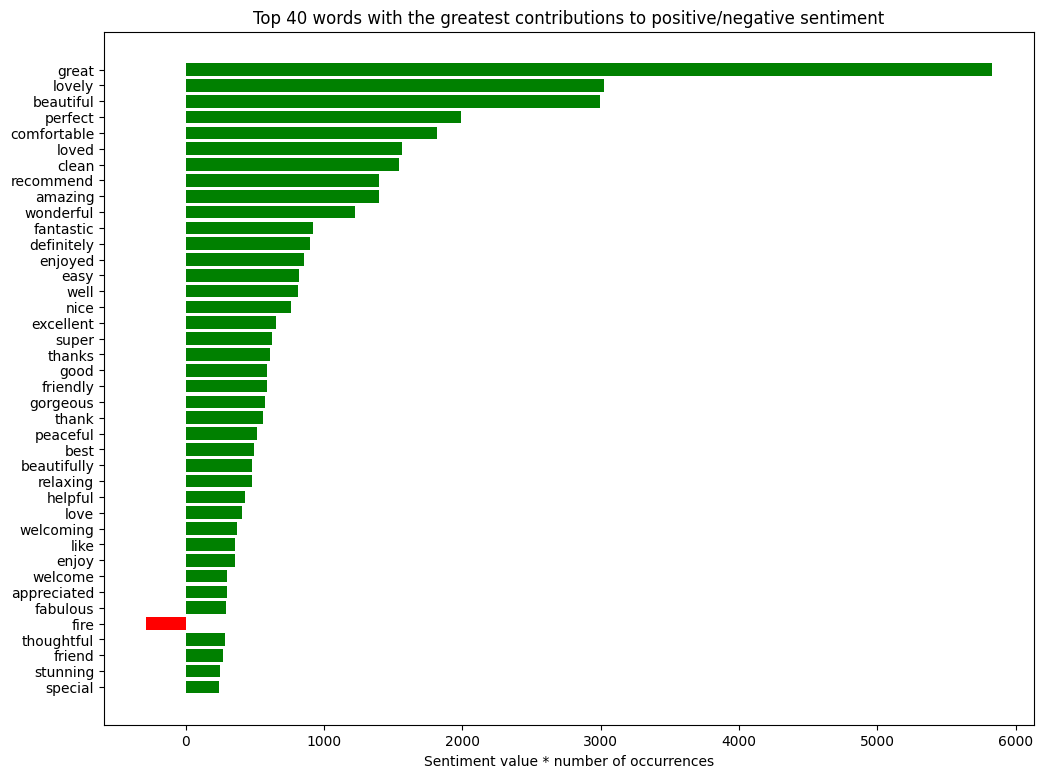

In [ ]:
def plot_top_sentiment_contributors(reviews_df, text_column, num_words=40):
    """
    Plots the top N words contributing to the positive or negative sentiment of reviews.

    Parameters:
    reviews_df (pd.DataFrame): DataFrame containing the cleaned review text data.
    text_column (str): Name of the column containing the cleaned review text.
    num_words (int): Number of top words to display (default is 40).

    Returns:
    None: Displays the plot.
    """
    # Split text into words and create a DataFrame
    words = reviews_df[text_column].str.split(expand=True).stack().reset_index(drop=True)
    words_df = pd.DataFrame(words, columns=['word'])

    # Initialize sentiment analyzer
    sia = SentimentIntensityAnalyzer()

    # Calculate sentiment scores for each word
    words_df['sentiment'] = words_df['word'].apply(lambda x: sia.polarity_scores(x)['compound'])

    # Calculate contributions by summing sentiment scores for each word
    contributions = words_df.groupby('word')['sentiment'].sum().reset_index(name='contribution')

    # Select top N words with the greatest contributions
    top_words = contributions.reindex(contributions['contribution'].abs().sort_values(ascending=False).index).head(num_words)

    # Assign colors based on contribution
    colors = ['red' if x < 0 else 'green' for x in top_words['contribution']]

    # Plot the results
    plt.figure(figsize=(12, 9))
    plt.barh(top_words['word'], top_words['contribution'], color=colors)
    plt.xlabel('Sentiment value * number of occurrences')
    plt.title(f'Top {num_words} words with the greatest contributions to positive/negative sentiment')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest contribution at the top
    plt.show()

# Example usage:
plot_top_sentiment_contributors(english_reviews_df, 'cleaned_text', 40)


# Lets dive deeper into the reviews having the word fire for further analysis

In [ ]:


# Assuming english_reviews_df is your DataFrame and cleaned_text is the column with preprocessed reviews
filtered_reviews_df = english_reviews_df[english_reviews_df['cleaned_text'].str.contains(r'\bfire\b', case=False, regex=True)]

# Display the filtered DataFrame
#print(filtered_reviews_df)



# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to classify sentiment
def classify_sentiment(review):
    scores = sia.polarity_scores(review)
    compound = scores['compound']
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to classify sentiment of each review
filtered_reviews_df['sentiment'] = filtered_reviews_df['cleaned_text'].apply(classify_sentiment)

# Count the number of positive, negative, and neutral reviews
sentiment_counts = filtered_reviews_df['sentiment'].value_counts()
print(sentiment_counts)

# Visualize the sentiment distribution (optional)
import matplotlib.pyplot as plt

sentiment_counts.plot(kind='bar', color=['green', 'red', 'gray'])
plt.title('Sentiment Distribution of Reviews Containing the Word "Fire"')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()




##  801 reviews contains  the word "fire" and only three have a negative sentiment. Let's examine the content of these reviews

In [ ]:
# Display the full content of the negative reviews
bad_reviews = filtered_reviews_df[filtered_reviews_df["sentiment"] == 'negative'].cleaned_text
for i, review in enumerate(bad_reviews, 1):
    print(f"Review {i}:")
    print(review)
    print("\n" + "="*80 + "\n")

Review 1:
booking process fine however room quite tired hotch potch furniture provided lacked appreciable decor theme lovely wood fire old inefficient split system air con couldnt keep chill room unfortunately toilet broken end decided stay night room would probably fine people night probably better option around


Review 2:
house presented beautifully inside well stocked fridge couple day breakfast supply heating open fire pay extra wood st use night wasnt cheaper st night clearly didnt enough research thought location bit far stay ruined maria blamed stain sheet group already wanted


Review 3:
idyllic cottage modern touch large outside deck summer day cozy fire winter walking distance cafe boutique restaurant real taste barossa done right




**Review 1:**
- **Problems:**
  - Room decor is outdated and mismatched.
  - Inefficient heating and cooling system.
  - Broken toilet.
- **Suggestions:**
  - Update the room's furniture and decor to create a cohesive and appealing theme.
  - Replace or service the heating and cooling system to ensure comfort.
  - Ensure all amenities, including toilets, are in working condition before guests arrive.

**Review 2:**
- **Problems:**
  - Extra charge for firewood was unexpected.
  - Stained sheets.
  - Perception of the location being too far.
- **Suggestions:**
  - Clearly communicate any additional charges during the booking process.
  - Ensure all linens are clean and stain-free.
  - Provide detailed location information to set accurate expectations.

**Review 3:**
- **Problems:**
  - None mentioned explicitly.
  - Positive aspects include cozy fire in winter and walking distance to cafes and restaurants.
- **Suggestions:**
  - Emphasize the positive features, such as the cozy fire and proximity to local attractions, in marketing materials.
  - Maintain these features consistently to meet guest expectations.

These suggestions aim to improve guest satisfaction by addressing the highlighted issues and leveraging positive feedback for marketing purposes.

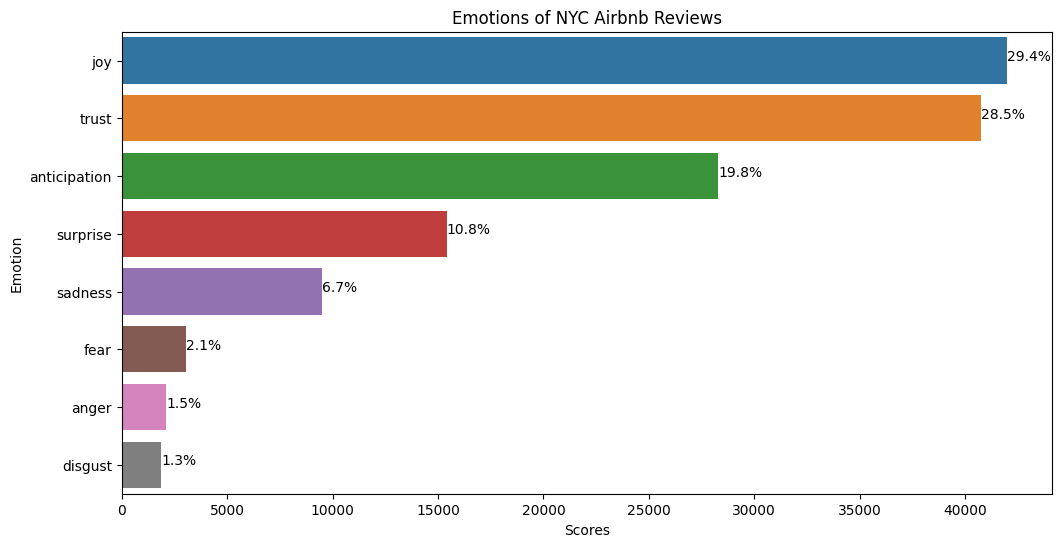

In [ ]:

from nrclex import NRCLex




# Extract words and their emotions using NRC
def get_nrc_sentiments(text):
    nrc = NRCLex(text)
    return pd.Series(nrc.raw_emotion_scores)

# Apply the function to each cleaned_text
emotion_scores = english_reviews_df['cleaned_text'].apply(get_nrc_sentiments)
emotion_scores.fillna(0, inplace=True)

# Separate positive/negative sentiments and emotions
sentiments = emotion_scores[['positive', 'negative']].sum().sort_values(ascending=False)
emotions = emotion_scores.drop(['positive', 'negative'], axis=1).sum().sort_values(ascending=False)

# Calculate percentages for sentiments and emotions
sentiment_pct = (sentiments / sentiments.sum()) * 100
emotion_pct = (emotions / emotions.sum()) * 100

# Create a DataFrame for plotting


emotion_df = emotion_pct.reset_index()
emotion_df.columns = ['emotion', 'percentage']
emotion_df['scores'] = emotions.values



# Plot emotions
plt.figure(figsize=(12, 6))
sns.barplot(x='scores', y='emotion', data=emotion_df, hue = 'emotion')
for index, row in emotion_df.iterrows():
    plt.text(row['scores'], index, f"{row['percentage']:.1f}%", color='black', ha="left")
plt.xlabel('Scores')
plt.ylabel('Emotion')
plt.title('Emotions of Baroosa Valley Australia Airbnb Reviews')
plt.show()


## The top three emotions in Barossa Valley Australia reviews from Airbnb are joy, trust and anticipation

C:\Users\Haier\AppData\Local\Temp\ipykernel_20056\345602834.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews_df.loc[:, 'sentiment'] = sentiment


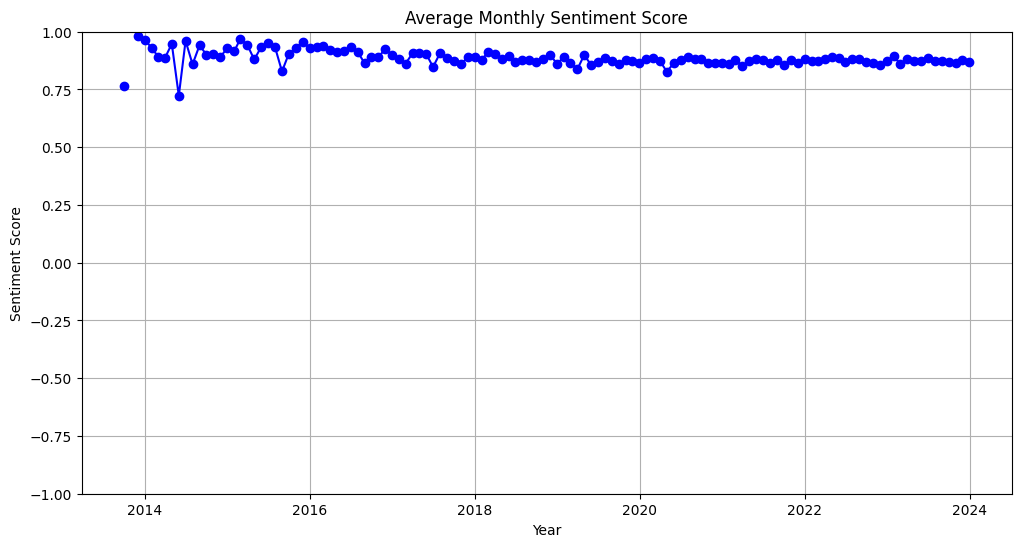

In [ ]:


# Initialize the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()


# Apply sentiment analysis
sentiment_scores = english_reviews_df['cleaned_text'].apply(sid.polarity_scores)

# Extract compound sentiment scores
sentiment = sentiment_scores.apply(lambda x: x['compound'])

# Add sentiment scores to the DataFrame using .loc
english_reviews_df.loc[:, 'sentiment'] = sentiment

# Set the date column as the index
english_reviews_df.set_index('date', inplace=True)

# Resample to monthly and calculate the mean sentiment score
monthly_sentiment = english_reviews_df['sentiment'].resample('M').mean()

# Plot the average monthly sentiment score
plt.figure(figsize=(12, 6))
plt.plot(monthly_sentiment, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.title('Average Monthly Sentiment Score')
plt.ylim(-1, 1)  # Sentiment scores range from -1 to 1
plt.grid(True)
plt.show()


The plot displays the average monthly sentiment scores of Airbnb reviews from customers in the Barossa Valley, Australia, over a span from 2014 to 2024. Here is an interpretation of the plot:

1. **Overall Sentiment**: The sentiment scores are generally high, consistently above 0.75, indicating predominantly positive reviews throughout the period.

2. **Initial Volatility**: There is some noticeable volatility in the sentiment scores during the early years (2014). This could be due to a lower volume of reviews, which might make the average more sensitive to individual negative reviews.

3. **Stabilization**: After the initial volatility, the sentiment scores stabilize and remain consistently high, close to 1.0. This suggests that the Airbnb properties in the Barossa Valley have maintained a high level of customer satisfaction over the years.

4. **Slight Fluctuations**: There are minor fluctuations in the sentiment scores throughout the period, but these do not significantly deviate from the high average. This indicates occasional variations in customer experiences but nothing drastic.

5. **Recent Consistency**: From around 2016 onwards, the sentiment scores exhibit remarkable consistency, indicating sustained high-quality experiences for customers.

In summary, the plot indicates that the Airbnb reviews for Barossa Valley, Australia, have been overwhelmingly positive over the past decade, with initial variability but long-term stability in customer satisfaction.

# Suggestions for Digital Marketing

-   To enhance digital and social media marketing for Barossa Valley, highlight positive guest experiences and showcase popular accommodation types like cottages and vacation homes. Emphasize the hospitality of local hosts and the region's high standards of cleanliness and comfort. Utilize stunning visuals to promote the natural beauty and key attractions, and leverage guest recommendations and user-generated content to build community and trust. Create engaging and informative content to frame Barossa Valley as a well-rounded and highly recommended destination.

### Suggested Action Plan:

1.  **Focus on Cleanliness**:

    Maintain and enhance cleaning protocols to exceed guest expectations and keep cleanliness a top priority.

<!-- -->

2.  **Enhance Location Information**:

    Provide detailed guides or digital apps with information about local attractions and transportation options to improve guest satisfaction.

<!-- -->

3.  **Improve Host Interaction**:

    Train hosts on hospitality and customer service to ensure positive guest experiences and encourage responsive and helpful interactions.

<!-- -->

4.  **Highlight Accommodation Types**:

    Clearly describe the type of accommodation in listings, emphasizing unique features to align with guest preferences.

<!-- -->

5.  **Monitor Guest Feedback**:

    Continuously track and analyze reviews to identify trends and implement a feedback system for prompt issue resolution and adaptation to guest needs.

<!-- -->

6.  **Leverage Positive Reviews**:

    Share guest testimonials with strong recommendations on social media to attract new guests.

7.  **Highlight Walking Distance Convenience**:

    Emphasize proximity to key attractions with engaging maps and guides.

8.  **Promote Comfort and Home-Like Experience**:

    Showcase the homely atmosphere with appealing visuals and guest quotes.

9.  **Showcase Aesthetic Appeal and Barossa Valley Attractions**:

    Regularly post high-quality images and promote local attractions to enhance digital marketing efforts.